In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import struct
import os

In [ ]:
# creating a class for the neural network containing all the functions required
class NeuralNetwork(nn.Module):

  # defining the constructor with layer sizes as parameters - 784, 128, 10 resp.
  def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_prob):
    # calling the constructor of the parent class - nn.Module
    super(NeuralNetwork, self).__init__()

    # defining the layers of the neural network

    self.fc1 = nn.Linear(input_size, hidden_size1)  #input layer to hidden layer
    self.bn1 = nn.BatchNorm1d(hidden_size1)  # BatchNorm for the hidden layer
    self.relu = nn.ReLU() # activation function for inp to hidden layer
    self.dropout = nn.Dropout(p=dropout_prob[0])  # Dropout layer with a probability

    self.fc2 = nn.Linear(hidden_size1, hidden_size2) # hidden layer to hidden layer
    self.bn2 = nn.BatchNorm1d(hidden_size2)  # BatchNorm for the hidden layer
    self.relu = nn.ReLU() # activation function for inp to hidden layer
    self.dropout = nn.Dropout(p=dropout_prob[1])  # Dropout layer with a probability

    self.fc3 = nn.Linear(hidden_size2, num_classes) # hidden layer to output layer


  # defining the forward propogation of the neural network
  def forward(self, x):
    out = self.fc1(x)
    out = self.bn1(out)  # Apply BatchNorm after the linear layer
    out = self.relu(out)
    out = self.dropout(out) # apply dropout to the output of activations of 1st layer

    out = self.fc2(out)
    out = self.bn2(out)  # Apply BatchNorm after the linear layer
    out = self.relu(out)
    out = self.dropout(out) # apply dropout to the output of activations of 2nd layer

    out = self.fc3(out)
    return out



In [ ]:
# check accuracy with train set and test set
def check_accuracy(loader, model, i):
  # setting the model to eval mode - regularisation, normalisation is stopped.
  model.eval()
  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for data, targets in loader:
      data = data.to(device=device)
      targets = targets.to(device=device)
      data = data.reshape(data.shape[0], -1)

      predictions = model(data)
      _, predictions = predictions.max(1)
      num_correct += (predictions == targets).sum()
      num_samples += predictions.size(0)

  acc  = float(num_correct)/float(num_samples)*100
  print(f"Accuracy after epoch {i}: {float(acc):.2f}\n")
  model.train() # setting back model to train mode.
  return acc


Cost after epoch 1: 1.8057228525479634
Accuracy after epoch 1: 75.51

Cost after epoch 2: 1.2597209513187408
Accuracy after epoch 2: 86.31

Cost after epoch 3: 0.9993454962968826
Accuracy after epoch 3: 88.97

Cost after epoch 4: 0.8209337145090103
Accuracy after epoch 4: 90.77

Cost after epoch 5: 0.701008583108584
Accuracy after epoch 5: 91.49

Cost after epoch 6: 0.6111485809087753
Accuracy after epoch 6: 92.00

Cost after epoch 7: 0.5462921261787415
Accuracy after epoch 7: 92.49

Cost after epoch 8: 0.5006799325346947
Accuracy after epoch 8: 92.85

Cost after epoch 9: 0.4660869315266609
Accuracy after epoch 9: 93.24

Cost after epoch 10: 0.4342443918188413
Accuracy after epoch 10: 93.58

Cost after epoch 11: 0.4091710646947225
Accuracy after epoch 11: 93.84

Cost after epoch 12: 0.3914171059926351
Accuracy after epoch 12: 94.19

Cost after epoch 13: 0.3706062411268552
Accuracy after epoch 13: 94.35

Cost after epoch 14: 0.353124479452769
Accuracy after epoch 14: 94.49

Cost after e

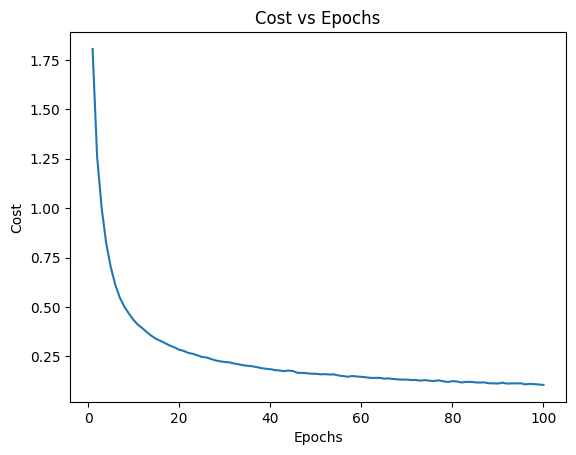

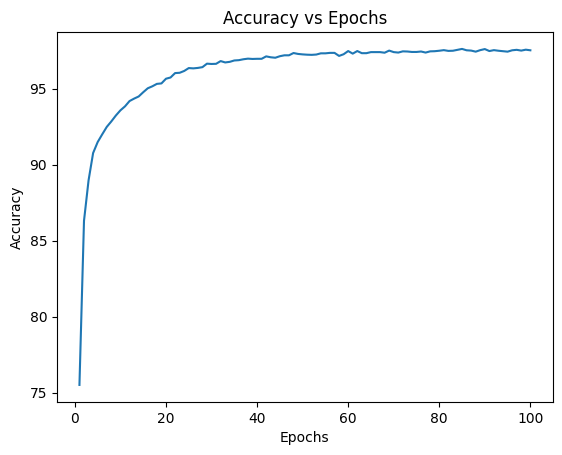

In [ ]:
# to specify the device which which process the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10
learning_rate = 0.001
batch_size = 5096
num_epochs = 100
dropout_prob = [0.2, 0.5]

# load data
def load_images(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # reshaped to 4D array - (nun of img, num of color channel, height, width of each img)
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)
        # numpy array converted to pytorch tensor
        images = torch.tensor(images, dtype=torch.float32)/255.0 # to normalise to [0, 1]
    return images

def load_labels(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        # numpy array of 8-bit unsigned ints
        labels = np.fromfile(f, dtype=np.uint8)
        # numpy array converted to a PyTorch tensor, with datatype = long
        labels = torch.tensor(labels, dtype=torch.long)
    return labels

train_x = load_images("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/train-images.idx3-ubyte")
train_y = load_labels("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/train-labels.idx1-ubyte")
test_x = load_images("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/t10k-images.idx3-ubyte")
test_y = load_labels("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/t10k-labels.idx1-ubyte")

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# below, shuffle=True so that we dont have same set of images in a batch in every epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# initialising the network by creating an instance of the class NeuralNetwork
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes, dropout_prob).to(device)

# loss function
# CrossEntropyLoss function implicitly applies softmax first, then calculates negative log likelihood loss
# hence we need not call the softmax function explicitly.
loss_func = nn.CrossEntropyLoss()

# Adam Optimiser
# model.parameters() to retrieve all the parameters of a NN model
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# training the network
cost_lst = []
accu_lst = []
for epoch in range(num_epochs):

  loss_epoch = 0
  for batch_index, (data, targets) in enumerate(train_loader):
    data = data.to(device=device)
    targets = targets.to(device=device)
    data = data.reshape(data.shape[0], -1)

    # forward propagation
    predictions = model(data)
    loss = loss_func(predictions, targets)
    loss_epoch += loss.item()

    # backward propagation
    optimiser.zero_grad() # zero_grad to set gradients back to 0 after every batch
    loss.backward() # weight updation

    # gradient descent through adam optimiser algo
    optimiser.step()

  cost_lst.append(loss_epoch/len(train_loader))
  print(f"Cost after epoch {epoch+1}: {loss_epoch/len(train_loader)}")

  accu = check_accuracy(test_loader, model, epoch+1)
  accu_lst.append(accu)


t = np.arange(1, num_epochs+1)
plt.plot(t, cost_lst)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.show()

plt.plot(t, accu_lst)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()
